### Importing Necessary Libraries

In [1]:
# !pip uninstall tensorflow -y
# !pip uninstall tensorflow-gpu -y

In [2]:
# !pip install -U tensorflow-gpu==2.10
# !pip install -U tensorflow==2.10

In [3]:
import os
import pickle
from tqdm import tqdm
import gc
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.applications import ResNet50V2
# from efficientnet_v2 import EfficientNetV2S 
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [4]:
os.listdir('../input/datathonindoml-2022')

['sample_submission.csv', 'validation', 'train_labels.csv', 'train']

In [5]:
labels = pd.read_csv("../input/datathonindoml-2022/train_labels.csv")
images = ['../input/datathonindoml-2022/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]
labels

,id,images,label
0,0,../input/datathonindoml-2022/train/train/0.tif,1
1,1,../input/datathonindoml-2022/train/train/1.tif,13
2,2,../input/datathonindoml-2022/train/train/2.tif,13
3,3,../input/datathonindoml-2022/train/train/3.tif,14
4,4,../input/datathonindoml-2022/train/train/4.tif,6
...,...,...,...
15995,15995,../input/datathonindoml-2022/train/train/15995...,2
15996,15996,../input/datathonindoml-2022/train/train/15996...,15
15997,15997,../input/datathonindoml-2022/train/train/15997...,3
15998,15998,../input/datathonindoml-2022/train/train/15998...,9


In [6]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

In [7]:
train_labels = pd.read_csv('../input/dataroi/train_labels_1.csv')
test_labels = pd.read_csv('../input/dataroi/test_labels_1.csv')
train_labels['images'] = ['../input/datathonindoml-2022/train/train/'+path.split('/')[-1] for path in list(train_labels['images'])]
test_labels['images'] = ['../input/datathonindoml-2022/validation/validation/'+path.split('/')[-1] for path in list(test_labels['images'])]
train_labels

,id,images,label
0,0,../input/datathonindoml-2022/train/train/0.tif,1
1,1,../input/datathonindoml-2022/train/train/1.tif,13
2,2,../input/datathonindoml-2022/train/train/2.tif,13
3,3,../input/datathonindoml-2022/train/train/3.tif,14
4,4,../input/datathonindoml-2022/train/train/4.tif,6
...,...,...,...
15195,15995,../input/datathonindoml-2022/train/train/15995...,2
15196,15996,../input/datathonindoml-2022/train/train/15996...,15
15197,15997,../input/datathonindoml-2022/train/train/15997...,3
15198,15998,../input/datathonindoml-2022/train/train/15998...,9


In [8]:
test_labels

,id,images,label
0,18,../input/datathonindoml-2022/validation/valida...,11
1,25,../input/datathonindoml-2022/validation/valida...,8
2,33,../input/datathonindoml-2022/validation/valida...,6
3,41,../input/datathonindoml-2022/validation/valida...,1
4,65,../input/datathonindoml-2022/validation/valida...,14
...,...,...,...
795,15816,../input/datathonindoml-2022/validation/valida...,2
796,15824,../input/datathonindoml-2022/validation/valida...,2
797,15832,../input/datathonindoml-2022/validation/valida...,11
798,15863,../input/datathonindoml-2022/validation/valida...,15


In [9]:
roi_info = np.load('../input/roi-info/train_roi_viz.npy')

In [10]:
roi_info.shape

(16000, 100, 6)

## Data Preparation

We will be using the image data above and the ROI extraction data as explained [here](RoI-Extraction.ipynb).

In [11]:
BATCH_SIZE = 50
# INPUT_SHAPE = (800, 600) # --> Takes too much time on Kaggle
INPUT_SHAPE = (400, 300)

Now due to the quite varying nature of the ROI shapes, the following pre-processing steps on each ROI converts them to same shape as that of the original document images by resizing and padding with the maximum color in the ROI which is mostly white and sometimes greyish, etc.

In [12]:
def resize_and_pad_with_doc_max_col(img, f_target_height=INPUT_SHAPE[0], f_target_width=INPUT_SHAPE[1]):
    f_width = img.shape[1]
    f_height = img.shape[0]
    ratio = np.max([f_width / f_target_width, f_height / f_target_height])
    resized_height_float = f_height / ratio
    resized_width_float = f_width / ratio
    resized_height = tf.cast(
        np.floor(resized_height_float), dtype=tf.int32)
    resized_width = tf.cast(
        np.floor(resized_width_float), dtype=tf.int32)

    padding_height = (f_target_height - resized_height_float) / 2
    padding_width = (f_target_width - resized_width_float) / 2
    f_padding_height = np.floor(padding_height)
    f_padding_width = np.floor(padding_width)
    p_height = np.max([0, tf.cast(f_padding_height, dtype=tf.int32)])
    p_width = np.max([0, tf.cast(f_padding_width, dtype=tf.int32)])

    resized_padded_image = tf.image.resize_with_pad(img, f_target_height, f_target_width).numpy()
    white_color = np.max(resized_padded_image)
    resized_padded_image[:p_height, :] = white_color
    resized_padded_image[(f_target_height-p_height-1):, :] = white_color
    resized_padded_image[:, :p_width] = white_color
    resized_padded_image[:, (f_target_width-p_width-1):] = white_color
    return resized_padded_image

The data generator as created below does the following things:
- It uses the RoI extraction information and the image to extract the portions of the document image and returns a list of these snippet regions.

In [13]:
class ROIGenerator:
    def __init__(self, df, df_roi, X_col, roi_pad=5):
        self.paths = list(df[X_col])
        self.roi_info = df_roi
        self.num_images = df_roi.shape[0]
        self.roi_pad = roi_pad
        self.idx = 0
        
    def generate(self):
        while True:
            if self.idx >= self.num_images:
                self.idx = 0
            image_data = img_to_array(load_img(self.paths[self.idx]))
            roi_data = self.roi_info[self.idx]
            self.idx += 1
            yield [resize_and_pad_with_doc_max_col(image_data[max(0, int(y_top)-self.roi_pad):min(image_data.shape[0], int(y_bottom)+self.roi_pad), max(0, int(x_top)-self.roi_pad):min(image_data.shape[1], int(x_bottom)+self.roi_pad)]) if pad_mask == 1 else [[]] for x_top, y_top, x_bottom, y_bottom, roi_type, pad_mask in roi_data]

In [14]:
test_gen = ROIGenerator(
    df=train_labels,
    df_roi=roi_info,
    X_col='images'
)

Below is the generated ROI extractions per image depicted.

2022-10-08 05:20:49.310461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 05:20:49.380163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 05:20:49.380985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 05:20:49.388289: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

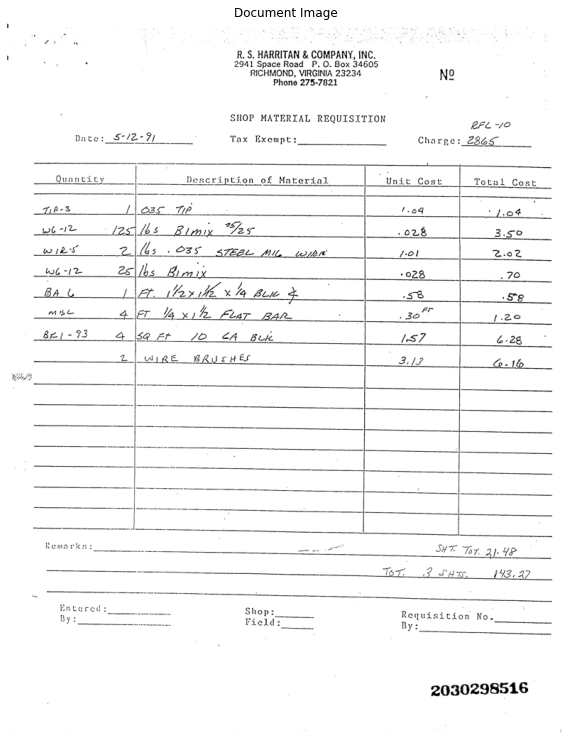

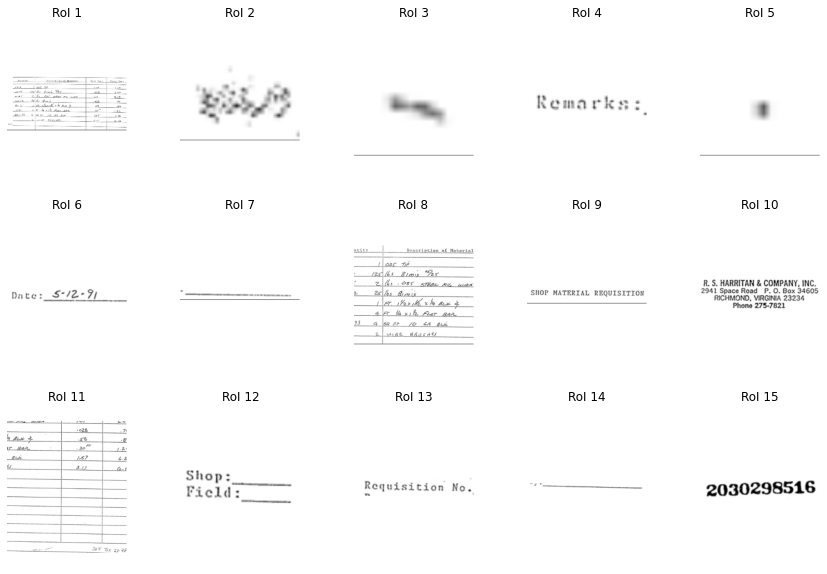

In [15]:
plt.figure(figsize=(10,20))
plt.imshow(tf.cast(img_to_array(load_img('../input/datathonindoml-2022/train/train/0.tif')), dtype=tf.uint8))
plt.axis('off')
plt.title("Document Image")

imgs = next(test_gen.generate())
fig, ax = plt.subplots(3, 5, figsize=(15,10))
k = 0
for i in range(3):
    for j in range(5):
        if len(imgs[k]) != 0:
            ax[i,j].imshow(tf.cast(imgs[k], dtype=tf.uint8))
            ax[i,j].axis('off')
            ax[i,j].set_title(f'RoI {k+1}')
        k += 1

Now, after we have seen how each document image is processed which is an extension to the [4 Piece Add On Model's](EfficientNet-4Piece-Model.ipynb) pre-processing which worked with only 4 pieces.

In [16]:
# class ImageDataGenerator:
#     def __init__(self, df, X_col, roi_info, y_col, batch_size, roi_pad=5, input_size=(800, 600), shuffle=True, base=0):
#         self.df = df.copy() # DataFrame consisting image paths of inputs and the labels for the outputs
#         self.X_col = X_col # Input column, specifying image path, in the DataFrame
#         self.roi_info = roi_info # Contains valid information for the pre-processing of each image
#         self.y_col = y_col # Output column, specifying corresponding label, in the DataFrame
#         self.batch_size = batch_size # Batch Size
#         self.roi_pad = roi_pad # Padding on 4 sides for each ROI
#         self.input_size = input_size # Input Image size
#         self.shuffle = shuffle # Shuffle Data after each epoch
#         self.n = len(self.df) # length of the entire data
#         self.base=base # base value
        
#     def __get_input(self, path):
#         image_data = img_to_array(load_img(path))
#         idx = int(path.split('/')[-1].split('.')[0]) - self.base
#         # some other pre-processing / data-augmentation goes here
#         roi_data = self.roi_info[idx]
#         return [resize_and_pad_with_doc_max_col(image_data[max(0, int(y_top)-self.roi_pad):min(image_data.shape[0], int(y_bottom)+self.roi_pad), max(0, int(x_top)-self.roi_pad):min(image_data.shape[1], int(x_bottom)+self.roi_pad)])/255.0 for x_top, y_top, x_bottom, y_bottom, roi_type, pad_mask in roi_data if pad_mask == 1]

#     def __get_data(self, batches):
#         batch_paths = batches[self.X_col]
#         batch_labels = batches[self.y_col]
#         X_batch = [np.array(self.__get_input(path)) for path in batch_paths]
#         y_batch = tf.cast(batch_labels, dtype=tf.float32)
#         return X_batch, y_batch
    
#     def __getitem__(self, index):
#         batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
#         X, y = self.__get_data(batches)
#         return X, y
    
#     def __len__(self):
#         return self.n // self.batch_size

class ImageDataGenerator:
    def __init__(self, df, X_col, roi_info, y_col, batch_size, roi_pad=5, input_size=(800, 600), shuffle=True, base=0):
        self.df = df.copy() # DataFrame consisting image paths of inputs and the labels for the outputs
        self.X_col = X_col # Input column, specifying image path, in the DataFrame
        self.roi_info = roi_info # Contains valid information for the pre-processing of each image
        self.y_col = y_col # Output column, specifying corresponding label, in the DataFrame
        self.batch_size = batch_size # Batch Size
        self.roi_pad = roi_pad # Padding on 4 sides for each ROI
        self.input_size = input_size # Input Image size
        self.shuffle = shuffle # Shuffle Data after each epoch
        self.n = len(self.df) # length of the entire data
        self.base=base # base value
    
    # def preprocess(self, image):  
    #     return (tf.cast(image, dtype=tf.float32) - 128.00) / 128.00
        
    def __get_input(self, path):
        image_data = img_to_array(load_img(path))
        idx = int(path.split('/')[-1].split('.')[0]) - self.base
        # some other pre-processing / data-augmentation goes here
        roi_data = self.roi_info[idx]
        return [tf.keras.applications.resnet_v2.preprocess_input (resize_and_pad_with_doc_max_col(image_data[max(0, int(y_top)-self.roi_pad):min(image_data.shape[0], int(y_bottom)+self.roi_pad), max(0, int(x_top)-self.roi_pad):min(image_data.shape[1], int(x_bottom)+self.roi_pad)])) for x_top, y_top, x_bottom, y_bottom, roi_type, pad_mask in roi_data if pad_mask == 1]

    def __get_data(self, batches):
        batch_paths = batches[self.X_col]
        batch_labels = batches[self.y_col]
        X_batch = [np.array(self.__get_input(path)) for path in batch_paths]
        y_batch = tf.cast(batch_labels, dtype=tf.float32)
        return X_batch, y_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [17]:
train_generator = ImageDataGenerator(
    df=labels,
    X_col='images',
    roi_info=roi_info,
    y_col='label',
    batch_size=BATCH_SIZE,
    input_size=INPUT_SHAPE,
    shuffle=False
)

In [18]:
# batch = train_generator[0]
# print('*** Batch Overview ***')
# print('Batch Size:', len(batch[0]))
# for i in range(BATCH_SIZE):
#     print(f'Number of ROIs for the {i+1}th input image:', batch[0][i].shape[0])
# print('ROI Dimensions:', batch[0][0].shape[1:])
# print('Output Label Tensor Shape:', batch[1].shape)
# del batch

Because of too many images, the batch visualization is not provided but it is similar to that of above shown for one document which is equivalent to batch size of 1.

## Model Building

After building a couple of CNN models consdering only the entire document image [EfficientNet Only Model](EfficientNet-Only-Model.ipynb) and [4 Piece Add On Model](EfficientNet-4Piece-Model.ipynb). It is now time to build much more better models considering other structures we will start by incorporating the ROI visual features and then later much more.

We will use the following pre-trained model to learn features for these ROIs.

- EfficientNetV2S

The EfficientNetV2S is a large model and since, we are not pre-training the entire model, we will just fine-tune it with few extra layers. So, to fasten training we precompute the output of the EfficientNetV2S model and use this for training the added Dense Layers for Fine-Tuning.

In [19]:
# model_xception = Xception(weights="imagenet", input_shape=(*INPUT_SHAPE, 3), include_top=False)
# model_effnet = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(*INPUT_SHAPE, 3))
model_resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=(*INPUT_SHAPE, 3))
model_resnet.trainable = False
# model_xception.trainable = False

94683136/94668760 [==============================] - 1s 0us/step


In [20]:
inp = Input(shape=(*INPUT_SHAPE, 3))
out = model_resnet(inp, training=False)
# out = model_xception(inp, training=False)
output = GlobalAvgPool2D()(out)
model = tf.keras.Model(inp, output, name='ResNet-kPiece')
# model = tf.keras.Model(inp, output, name='Xception-kPiece')

In [21]:
model.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [22]:
model.summary()

Model: "ResNet-kPiece"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 300, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 13, 10, 2048)      23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 23,564,800
Trainable params: 0
Non-trainable params: 23,564,800
_________________________________________________________________


### Training Data

In [23]:
train_generator_precompute = ImageDataGenerator(
    df=labels,
    X_col='images',
    roi_info=roi_info,
    y_col='label',
    batch_size=BATCH_SIZE,
    input_size=INPUT_SHAPE,
    shuffle=False
)

checkpnt_each = 100
assert checkpnt_each % BATCH_SIZE == 0
checkpnt_i = checkpnt_each // BATCH_SIZE
precompute_output = list()

To avoid memory issues the vector representation of the ROIs of one document is followed immediately by the vectors for the ROIs of the next document. So, when using we will have to keep that in mind. Also, if no ROI is found in a document image then that is simply skipped, and must be handled later.

In [24]:
prev_crash_i = 0 # Set it to the value of i where the previous running of this cell crashed, if running for first time set it to 0
for i in range(prev_crash_i, 16000//BATCH_SIZE):
    print(f'{i+1}th Batch')
    batch = train_generator_precompute[i]
    batch = [x for x in batch[0] if len(x.shape) == 4] # Sometimes a document image has no ROI handles that
    batch = tf.concat(batch, axis=0) # Concatenating the ROIs of each document image togetheraq
    precompute_output.append(model.predict(batch))
    tf.keras.backend.clear_session()
    _ = gc.collect()
    if (i+1) % checkpnt_i == 0:
        precompute_output = tf.concat(precompute_output, axis=0).numpy()
        # np.save(f'./Data/EffNet-kP-train-precompute/train_data_precomp-{(i+1)//checkpnt_i}.npy', precompute_output)
        np.save(f'train_data_precomp-{(i+1)//checkpnt_i}.npy', precompute_output)
        precompute_output = list()
        del batch

1th Batch


2022-10-08 05:21:02.688760: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1236960000 exceeds 10% of free system memory.
2022-10-08 05:21:03.715178: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-08 05:21:05.332941: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2th Batch


2022-10-08 05:21:20.435378: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1169280000 exceeds 10% of free system memory.


3th Batch


2022-10-08 05:21:29.928039: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1019520000 exceeds 10% of free system memory.


4th Batch


2022-10-08 05:21:41.677860: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1186560000 exceeds 10% of free system memory.


5th Batch


2022-10-08 05:21:53.152464: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1049760000 exceeds 10% of free system memory.


6th Batch
7th Batch
8th Batch
9th Batch
10th Batch
11th Batch
12th Batch
13th Batch
14th Batch
15th Batch
16th Batch
17th Batch
18th Batch
19th Batch
20th Batch
21th Batch
22th Batch
23th Batch
24th Batch
25th Batch
26th Batch
27th Batch
28th Batch
29th Batch
30th Batch
31th Batch
32th Batch
33th Batch
34th Batch
35th Batch
36th Batch
37th Batch
38th Batch
39th Batch
40th Batch
41th Batch
42th Batch
43th Batch
44th Batch
45th Batch
46th Batch
47th Batch
48th Batch
49th Batch
50th Batch
51th Batch
52th Batch
53th Batch
54th Batch
55th Batch
56th Batch
57th Batch
58th Batch
59th Batch
60th Batch
61th Batch
62th Batch
63th Batch
64th Batch
65th Batch
66th Batch
67th Batch
68th Batch
69th Batch
70th Batch
71th Batch
72th Batch
73th Batch
74th Batch
75th Batch
76th Batch
77th Batch
78th Batch
79th Batch
80th Batch
81th Batch
82th Batch
83th Batch
84th Batch
85th Batch
86th Batch
87th Batch
88th Batch
89th Batch
90th Batch
91th Batch
92th Batch
93th Batch
94th Batch
95th Batch
96th Batch
97t

In [25]:
# for i in tqdm(range(1, 17)):
#     with ZipFile(f'result-{i}.zip', 'w') as zipObj:
#         for j in range(1, 11):
#             zipObj.write(f'./train_data_precomp-{(i*10+j)-10}.npy')

After the feature vectors being generated for each ROI. We will now try different methods to combine the RoIs for each document to come up with a better representation vector for the overall document image which will then go into the fine-tuning extra layers.

In [26]:
# roi_count = [np.sum([roi[-1]==1 for roi in doc]) for doc in roi_info] # RoIs per document Image

In [27]:
# max(roi_count)

In [28]:
# fine_tune_data = list()
# for i in range(16000 // (BATCH_SIZE*checkpnt_i)):
#     k = 0
#     batch_data = np.load(f'./train_data_precomp-{i+1}.npy')
#     batch_roi = roi_count[(i*(BATCH_SIZE*checkpnt_i)):((i+1)*(BATCH_SIZE*checkpnt_i))]
#     for j in range(BATCH_SIZE*checkpnt_i):
#         fine_tune_data.append(np.concatenate([batch_data[k:(k+batch_roi[j])], np.zeros((100-batch_roi[j], 1280))])[np.newaxis,:])
#         k += batch_roi[j]
# fine_tune_data = np.concatenate(fine_tune_data)

In [29]:
# fine_tune_data.shape

In [30]:
# np.save(f'./Data/EffNet-kP-train-precompute/whole_train_data_precomp.npy', fine_tune_data)

The EfficientNetV2L gives a 3D output per image with $1280$ channels which are collapsed using GlobalAveragePooling2D and we get a 1280 representation vector per ROI. Now, since there are multiple ROIs per image we need to come up with a single vector containing all these information, later we will see a method to not throw this information away. But as of now this single vector summarizing the ROI feature vectors is calculated using average. We will combine this information with the $4$ Piece fine-tune data i.e. we will stack this ROI feature vector with the those 4 image piece feature vectors and a final feature vector for the entire image.

In [31]:
# fine_tune_data = np.load(f'./Data/EffNet-kP-train-precompute/whole_train_data_precomp.npy')
# fine_tune_data.shape

In [32]:
# fine_tune_data = np.squeeze(np.mean(fine_tune_data, axis=1, keepdims=True))
# fine_tune_data.shape

In [33]:
# fine_tune_data_4P = np.load('./Data/EffNet-4P-train-precompute/whole_train_data_precomp.npy')
# fine_tune_data_4P = np.reshape(fine_tune_data_4P, (16000, -1))
# fine_tune_data_4P.shape

In [34]:
# fine_tune_data = np.concatenate([fine_tune_data, fine_tune_data_4P], axis=-1)
# fine_tune_data.shape

In [35]:
# np.save(f'./Data/EffNet-kP-train-precompute/whole_train_data_precomp_roi_n_4p.npy', fine_tune_data)

In [36]:
# fine_tune_labels = labels['label'].to_numpy()
# fine_tune_labels.shape

### Validation Data

In [37]:
validation_data = pd.DataFrame({'images':['../input/datathonindoml-2022/validation/validation/'+name for name in os.listdir('../input/datathonindoml-2022/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('../input/datathonindoml-2022/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
57,../input/datathonindoml-2022/validation/valida...,17801,-1
141,../input/datathonindoml-2022/validation/valida...,17802,-1
777,../input/datathonindoml-2022/validation/valida...,17803,-1
273,../input/datathonindoml-2022/validation/valida...,17804,-1
30,../input/datathonindoml-2022/validation/valida...,17805,-1
...,...,...,...
396,../input/datathonindoml-2022/validation/valida...,18696,-1
111,../input/datathonindoml-2022/validation/valida...,18697,-1
817,../input/datathonindoml-2022/validation/valida...,18698,-1
710,../input/datathonindoml-2022/validation/valida...,18699,-1


In [38]:
roi_info_validation = np.load('../input/roiinfo/validation_roi_viz.npy')
roi_info_validation.shape

(900, 100, 6)

In [39]:
validation_generator_precompute = ImageDataGenerator(
    df=validation_data,
    X_col='images',
    roi_info=roi_info_validation,
    y_col='label',
    batch_size=BATCH_SIZE,
    input_size=INPUT_SHAPE,
    shuffle=False,
    base=17801
)

checkpnt_each = 100
assert checkpnt_each % BATCH_SIZE == 0
checkpnt_i = checkpnt_each // BATCH_SIZE
precompute_output = list()

In [40]:
prev_crash_i = 0 # Set it to the value of i where the previous running of this cell crashed, if running for first time set it to 0
for i in range(prev_crash_i, 900//BATCH_SIZE):
    print(f'{i+1}th Batch')
    batch = validation_generator_precompute[i]
    batch = [x for x in batch[0] if len(x.shape) == 4] # Sometimes a document image has no ROI handles that
    batch = tf.concat(batch, axis=0) # Concatenating the ROIs of each document image together
    precompute_output.append(model.predict(batch))
    precompute_output.append(model.predict(batch))
    tf.keras.backend.clear_session()
    _ = gc.collect()
    if (i+1) % checkpnt_i == 0:
        precompute_output = tf.concat(precompute_output, axis=0).numpy()
        np.save(f'validation_data_precomp-{(i+1)//checkpnt_i}.npy', precompute_output)
        precompute_output = list()
        del batch

1th Batch
2th Batch
3th Batch
4th Batch
5th Batch
6th Batch
7th Batch
8th Batch
9th Batch
10th Batch
11th Batch
12th Batch
13th Batch
14th Batch
15th Batch
16th Batch
17th Batch
18th Batch


In [41]:
# with ZipFile(f'result.zip', 'w') as zipObj:
#     for j in range(1, 10):
#         zipObj.write(f'./validation_data_precomp-{j}.npy')